<a href="https://colab.research.google.com/github/serivan/mldmlab/blob/master/Data_analysis_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis and Preprocessing

## Imports

The autoreload instruction reloads modules automatically before code execution, which is helpful for the update below.

In [1]:
%load_ext autoreload
%autoreload 2

Make sure that we have the latest version of pandas-profiling and scikit-learn.

In [2]:
import sys

!{sys.executable} -m pip install -U pandas-profiling[notebook]
!jupyter nbextension enable --py widgetsnbextension

!pip uninstall scikit-learn -y
!pip install -U scikit-learn


     |████████████████████████████████| 261 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 102 kB 3.6 MB/s ta 0:00:01
     |████████████████████████████████| 303 kB 5.9 MB/s eta 0:00:01
     |████████████████████████████████| 12.6 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 696 kB 9.5 MB/s eta 0:00:01
     |████████████████████████████████| 812 kB 6.9 MB/s eta 0:00:01


  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=2bbd5f6c666acc5627c0c10ee34400add4b63e244f06859d7862a0148ce71fbe
  Stored in directory: /home/iserina/.cache/pip/wheels/23/14/6e/4be5bfeeb027f4939a01764b48edd5996acf574b0913fe5243
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=92a2dee5efb6a041a576b1cc06b6c9d047edda48be1789158d9d4aaa93a8fd54
  Stored in directory: /home/iserina/.cache/pip/wheels/48/a1/7f/096c1269d6bf78d4768180602579b35a1e8cb1250bb4b40c74
Successfully built htmlmin imagehash
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 1.1.1
    Uninstalling MarkupSafe-1.1.1:
      Successfully uninstalled MarkupSafe-1.1.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
     |████████████████████████████████| 26.7 MB 139 kB/s  eta 0:00:01


In [4]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.tree import DecisionTreeClassifier

import requests
import pandas_profiling as pp
from pandas_profiling.utils.cache import cache_file

In [5]:
print(sk.__version__)

print(pd.__version__)

1.0.2
1.4.1


## Constants

In [6]:
DATA_PATH = "https://raw.githubusercontent.com/serivan/mldmlab/master/Kaggle/KAGGLE/"
RANDOM_STATE = 3993
COLLINEAR_THRESHOLD = 0.9
K_FEATURES = 3

## Load Data

In [7]:
dataset = pd.read_csv(DATA_PATH + "train.csv")

# Save the target column and drop the target
target = dataset["target"]
dataset.drop(columns="target", inplace=True)
# Sort columns by name
dataset.sort_index(axis="columns", inplace=True)
# Print first samples
dataset

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000  62.0              2.0        213.0              0.0   
1     1001  72.0              3.0          2.0              0.0   
2     1002  49.0              3.0        183.0              0.0   
3     1003  35.0              2.0          NaN              0.0   
4     1004  51.0              4.0         -4.0              0.0   
...    ...   ...              ...          ...              ...   
1296  2296  66.0              4.0        227.0              0.0   
1297  2297  51.0              3.0        251.0              0.0   
1298  2298  42.0              2.0        294.0              0.0   
1299  2299  41.0              2.0        161.0              0.0   
1300  2300  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

## Missing Values

Reasons for missing values
- Information is not collected (e.g., people decline to give their age and weight)
- Attributes may not be applicable to all cases (e.g., annual income is not applicable to children)

Handling missing values
- Eliminate Data Objects
- Estimate Missing Values
- Ignore the Missing Value During Analysis
- Replace with all possible values (weighted by their probabilities)

In [8]:
def count_missing(ds: pd.DataFrame):
    return ds.shape[0] - ds.count()

In [9]:
count_missing(dataset)

Id                       0
age                      4
chest_pain_type          9
cholesterol            202
exercise_angina          3
fasting_blood_sugar     11
max_heart_rate           7
oldpeak                  8
pulse                    3
resting_bp_s             7
resting_ecg              3
sex                      8
st_slope                 1
synt                     0
dtype: int64

In [10]:
# Better visualization for missing count sorted by column
count_missing(dataset).sort_values().plot.barh()

<AxesSubplot:>

In [11]:
def get_sample_with_nans(ds: pd.DataFrame):
    return ds.loc[ds.isna().any(axis=1)]

In [12]:
get_sample_with_nans(dataset)

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003  35.0              2.0          NaN              0.0   
6     1006  66.0              4.0          NaN              0.0   
8     1008  65.0              1.0          NaN              0.0   
10    1010  41.0              2.0          NaN              0.0   
13    1013  54.0              4.0          NaN              1.0   
...    ...   ...              ...          ...              ...   
1274  2274  44.0              2.0          NaN              0.0   
1278  2278  63.0              NaN         -3.0              0.0   
1280  2280  60.0              NaN        254.0              0.0   
1289  2289  45.0              2.0          NaN              0.0   
1295  2295  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  NaN       1.0  0.001392  

[262 rows x 14 columns]

In [13]:
sample_with_nans_ids = get_sample_with_nans(dataset).index
sample_with_nans_ids

Int64Index([   3,    6,    8,   10,   13,   20,   27,   29,   32,   34,
            ...
            1248, 1249, 1253, 1254, 1269, 1274, 1278, 1280, 1289, 1295],
           dtype='int64', length=262)

### Eliminate Data Objects

In [14]:
dataset_no_nans = dataset.dropna()
dataset_no_nans

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000  62.0              2.0        213.0              0.0   
1     1001  72.0              3.0          2.0              0.0   
2     1002  49.0              3.0        183.0              0.0   
4     1004  51.0              4.0         -4.0              0.0   
5     1005  55.0              2.0        339.0              0.0   
...    ...   ...              ...          ...              ...   
1296  2296  66.0              4.0        227.0              0.0   
1297  2297  51.0              3.0        251.0              0.0   
1298  2298  42.0              2.0        294.0              0.0   
1299  2299  41.0              2.0        161.0              0.0   
1300  2300  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
5                     0.0           166.0  1.235293  417.0         131.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
4             0.0  1.0       2.0  0.790254  
5             0.0  0.0       1.0  0.087656  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1039 rows x 14 columns]

In [15]:
count_missing(dataset_no_nans)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [16]:
try:
    dataset_no_nans.loc[sample_with_nans_ids]
except KeyError:
    print("Ids of desired samples are not in dataset!")

Ids of desired samples are not in dataset!


### Impute Missing Values

Estimate missing values can be performed using both pandas and scikit-learn.
We use scikit-learn because it helps with machine learning.

In [17]:
def array_to_dataframe(arr: np.ndarray, columns: List[str]):
    return pd.DataFrame(data=arr, columns=columns)

#### Impute with constant

In [18]:
constant_imp_arr = SimpleImputer(strategy="constant", fill_value=-1).fit_transform(
    dataset
)
constant_imp_arr

array([[1.00000000e+03, 6.20000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 5.36459125e-01],
       [1.00100000e+03, 7.20000000e+01, 3.00000000e+00, ...,
        1.00000000e+00, 2.00000000e+00, 3.34896503e-01],
       [1.00200000e+03, 4.90000000e+01, 3.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 7.20857711e-01],
       ...,
       [2.29800000e+03, 4.20000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 8.49484851e-01],
       [2.29900000e+03, 4.10000000e+01, 2.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 4.35816087e-01],
       [2.30000000e+03, 5.30000000e+01, 3.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 4.05372091e-01]])

In [19]:
constant_imp_df = array_to_dataframe(constant_imp_arr, dataset.columns)

In [20]:
count_missing(constant_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [21]:
constant_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0              2.0         -1.0              0.0   
6     1006.0  66.0              4.0         -1.0              0.0   
8     1008.0  65.0              1.0         -1.0              0.0   
10    1010.0  41.0              2.0         -1.0              0.0   
13    1013.0  54.0              4.0         -1.0              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0              2.0         -1.0              0.0   
1278  2278.0  63.0             -1.0         -3.0              0.0   
1280  2280.0  60.0             -1.0        254.0              0.0   
1289  2289.0  45.0              2.0         -1.0              0.0   
1295  2295.0  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0 -1.0       1.0  0.001392  

[262 rows x 14 columns]

#### Impute with mean or median

In [22]:
median_imp_arr = SimpleImputer(strategy="median").fit_transform(dataset)
median_imp_df = array_to_dataframe(arr=median_imp_arr, columns=dataset.columns)
median_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0        213.0              0.0   
1     1001.0  72.0              3.0          2.0              0.0   
2     1002.0  49.0              3.0        183.0              0.0   
3     1003.0  35.0              2.0        230.0              0.0   
4     1004.0  51.0              4.0         -4.0              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0        227.0              0.0   
1297  2297.0  51.0              3.0        251.0              0.0   
1298  2298.0  42.0              2.0        294.0              0.0   
1299  2299.0  41.0              2.0        161.0              0.0   
1300  2300.0  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

In [23]:
count_missing(median_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [24]:
median_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0              2.0        230.0              0.0   
6     1006.0  66.0              4.0        230.0              0.0   
8     1008.0  65.0              1.0        230.0              0.0   
10    1010.0  41.0              2.0        230.0              0.0   
13    1013.0  54.0              4.0        230.0              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0              2.0        230.0              0.0   
1278  2278.0  63.0              3.0         -3.0              0.0   
1280  2280.0  60.0              3.0        254.0              0.0   
1289  2289.0  45.0              2.0        230.0              0.0   
1295  2295.0  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  1.0       1.0  0.001392  

[262 rows x 14 columns]

#### Impute with KNearestNeighbours

In [25]:
knn_imp_arr = KNNImputer().fit_transform(dataset)
knn_imp_df = array_to_dataframe(arr=knn_imp_arr, columns=dataset.columns)
knn_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0        213.0              0.0   
1     1001.0  72.0              3.0          2.0              0.0   
2     1002.0  49.0              3.0        183.0              0.0   
3     1003.0  35.0              2.0        246.8              0.0   
4     1004.0  51.0              4.0         -4.0              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0        227.0              0.0   
1297  2297.0  51.0              3.0        251.0              0.0   
1298  2298.0  42.0              2.0        294.0              0.0   
1299  2299.0  41.0              2.0        161.0              0.0   
1300  2300.0  53.0              3.0        245.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

In [26]:
count_missing(knn_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [27]:
knn_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0              2.0        246.8              0.0   
6     1006.0  66.0              4.0        201.8              0.0   
8     1008.0  65.0              1.0        196.0              0.0   
10    1010.0  41.0              2.0        212.4              0.0   
13    1013.0  54.0              4.0        280.6              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0              2.0        248.0              0.0   
1278  2278.0  63.0              3.0         -3.0              0.0   
1280  2280.0  60.0              2.6        254.0              0.0   
1289  2289.0  45.0              2.0        218.6              0.0   
1295  2295.0  44.0              3.0        230.0              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg  sex  st_slope      synt  
3             2.0  1.0       1.0  0.117560  
6             0.0  1.0       1.0  0.204944  
8             0.0  1.0       1.0  0.854541  
10            0.0  0.0       1.0  0.013972  
13            1.0  1.0       2.0  0.844455  
...           ...  ...       ...       ...  
1274          0.0  1.0       1.0  0.328454  
1278          1.0  1.0       1.0  0.457896  
1280          2.0  0.0       2.0  0.886322  
1289          2.0  1.0       1.0  0.602137  
1295          0.0  0.4       1.0  0.001392  

[262 rows x 14 columns]

#### Impute with IterativeImputer ([BayesianRidge](https://www.tutorialspoint.com/scikit_learn/scikit_learn_bayesian_ridge_regression.htm))

In [28]:
iter_imp_arr = IterativeImputer().fit_transform(dataset)
iter_imp_df = array_to_dataframe(arr=iter_imp_arr, columns=dataset.columns)
iter_imp_df

Id   age  chest_pain_type  cholesterol  exercise_angina  \
0     1000.0  62.0              2.0   213.000000              0.0   
1     1001.0  72.0              3.0     2.000000              0.0   
2     1002.0  49.0              3.0   183.000000              0.0   
3     1003.0  35.0              2.0   241.948813              0.0   
4     1004.0  51.0              4.0    -4.000000              0.0   
...      ...   ...              ...          ...              ...   
1296  2296.0  66.0              4.0   227.000000              0.0   
1297  2297.0  51.0              3.0   251.000000              0.0   
1298  2298.0  42.0              2.0   294.000000              0.0   
1299  2299.0  41.0              2.0   161.000000              0.0   
1300  2300.0  53.0              3.0   245.000000              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
0                     1.0           141.0 -0.051026  348.0         128.0   
1                     0.0           115.0  1.626599  287.0         159.0   
2                     0.0           156.0  0.968111  391.0         161.0   
3                     0.0           179.0  0.021913  449.0         119.0   
4                     1.0           104.0 -0.010970  258.0         120.0   
...                   ...             ...       ...    ...           ...   
1296                  0.0           137.0  2.333775  343.0         161.0   
1297                  0.0           148.0  0.530301  376.0         130.0   
1298                  0.0           161.0 -0.011372  406.0         121.0   
1299                  0.0           183.0 -0.025241  454.0         120.0   
1300                  1.0           173.0 -0.001958  431.0         131.0   

      resting_ecg  sex  st_slope      synt  
0             2.0  1.0       1.0  0.536459  
1             2.0  1.0       2.0  0.334897  
2             0.0  0.0       2.0  0.720858  
3             2.0  1.0       1.0  0.117560  
4             0.0  1.0       2.0  0.790254  
...           ...  ...       ...       ...  
1296          2.0  1.0       1.0  0.585738  
1297          2.0  0.0       1.0  0.318384  
1298          0.0  1.0       1.0  0.849485  
1299          0.0  1.0       1.0  0.435816  
1300          2.0  1.0       1.0  0.405372  

[1301 rows x 14 columns]

In [29]:
count_missing(iter_imp_df)

Id                     0
age                    0
chest_pain_type        0
cholesterol            0
exercise_angina        0
fasting_blood_sugar    0
max_heart_rate         0
oldpeak                0
pulse                  0
resting_bp_s           0
resting_ecg            0
sex                    0
st_slope               0
synt                   0
dtype: int64

In [30]:
iter_imp_df.loc[sample_with_nans_ids]

Id   age  chest_pain_type  cholesterol  exercise_angina  \
3     1003.0  35.0         2.000000   241.948813              0.0   
6     1006.0  66.0         4.000000   212.236078              0.0   
8     1008.0  65.0         1.000000   216.556468              0.0   
10    1010.0  41.0         2.000000   230.463307              0.0   
13    1013.0  54.0         4.000000   195.190031              1.0   
...      ...   ...              ...          ...              ...   
1274  2274.0  44.0         2.000000   206.452784              0.0   
1278  2278.0  63.0         2.744644    -3.000000              0.0   
1280  2280.0  60.0         2.790945   254.000000              0.0   
1289  2289.0  45.0         2.000000   236.396242              0.0   
1295  2295.0  44.0         3.000000   230.000000              0.0   

      fasting_blood_sugar  max_heart_rate   oldpeak  pulse  resting_bp_s  \
3                     0.0           179.0  0.021913  449.0         119.0   
6                     0.0           141.0  1.480206  347.0         113.0   
8                     0.0           134.0  0.261265  337.0         141.0   
10                    0.0           162.0  0.021463  407.0         126.0   
13                    0.0           117.0  1.451523  294.0         131.0   
...                   ...             ...       ...    ...           ...   
1274                  0.0           136.0 -0.018937  338.0         129.0   
1278                  1.0           154.0  3.648962  388.0         149.0   
1280                  0.0           156.0  2.630425  392.0         150.0   
1289                  0.0           169.0  0.015662  422.0         127.0   
1295                  0.0           168.0  0.023068  422.0         119.0   

      resting_ecg       sex  st_slope      synt  
3             2.0  1.000000       1.0  0.117560  
6             0.0  1.000000       1.0  0.204944  
8             0.0  1.000000       1.0  0.854541  
10            0.0  0.000000       1.0  0.013972  
13            1.0  1.000000       2.0  0.844455  
...           ...       ...       ...       ...  
1274          0.0  1.000000       1.0  0.328454  
1278          1.0  1.000000       1.0  0.457896  
1280          2.0  0.000000       2.0  0.886322  
1289          2.0  1.000000       1.0  0.602137  
1295          0.0  0.627291       1.0  0.001392  

[262 rows x 14 columns]

## Aggregation 

Combining two or more attributes (or objects) into a single attribute (or object)

Purpose
- Data reduction: Reduce the number of attributes or objects
- Change of scale: Cities aggregated into regions, states, countries, etc
- More “stable” data: Aggregated data tends to have less variability 



See also https://www.tutorialspoint.com/scikit_learn/scikit_learn_bayesian_ridge_regression.htm

In [31]:
dataset.groupby([ 'sex', 'chest_pain_type']).size().unstack()

chest_pain_type  1.0  2.0  3.0  4.0
sex                                
0.0               20  121  113  109
1.0               61  187  224  449

Another more flexible way is to use crosstab():

In [32]:
pd.crosstab(dataset['sex'], dataset['chest_pain_type'])


chest_pain_type  1.0  2.0  3.0  4.0
sex                                
0.0               20  121  113  109
1.0               61  187  224  449

In [33]:
pd.crosstab(dataset['sex'], dataset['chest_pain_type'], margins=True)

chest_pain_type  1.0  2.0  3.0  4.0   All
sex                                      
0.0               20  121  113  109   363
1.0               61  187  224  449   921
All               81  308  337  558  1284

In [34]:
pd.crosstab(dataset['sex'], dataset['chest_pain_type'], margins=True, normalize=True)

chest_pain_type       1.0       2.0       3.0       4.0      All
sex                                                             
0.0              0.015576  0.094237  0.088006  0.084891  0.28271
1.0              0.047508  0.145639  0.174455  0.349688  0.71729
All              0.063084  0.239875  0.262461  0.434579  1.00000

You can use groupby() with describe() for group summary statistics

In [35]:
dataset.groupby('sex')['chest_pain_type'].describe()

count      mean       std  min  25%  50%  75%  max
sex                                                    
0.0  363.0  2.856749  0.914208  1.0  2.0  3.0  4.0  4.0
1.0  921.0  3.152009  0.966121  1.0  2.0  3.0  4.0  4.0

In [36]:
dataset.groupby('sex')['chest_pain_type'].describe()

count      mean       std  min  25%  50%  75%  max
sex                                                    
0.0  363.0  2.856749  0.914208  1.0  2.0  3.0  4.0  4.0
1.0  921.0  3.152009  0.966121  1.0  2.0  3.0  4.0  4.0

You can use agg()/aggregate() for flexible aggregations

In [37]:
dataset.groupby(['sex']).agg({'chest_pain_type': ['mean', 'std']}) 

chest_pain_type          
               mean       std
sex                          
0.0        2.856749  0.914208
1.0        3.152009  0.966121

In [43]:
dataset.groupby(['sex']).agg({'chest_pain_type': ['mean', 'std'], 'cholesterol': ['mean', 'std']}) 

chest_pain_type           cholesterol            
               mean       std        mean         std
sex                                                  
0.0        2.943144  0.901217  252.899598   78.412076
1.0        3.235012  0.946300  199.420680  102.175264

and take advantage of pivot_table()

In [44]:
dataset.pivot_table(values='cholesterol', index='sex', columns='chest_pain_type')

chest_pain_type         1.0         2.0         3.0       4.0
sex                                                          
0.0              227.000000  257.768116  256.011765  245.3375
1.0              213.880952  225.474576  189.433735  194.0640

###  Data reduction

#### Drop collinear columns

In [45]:
def get_collinear_cols(ds: pd.DataFrame, coll_threshold: float):
    # Compute correlation matrix using pearson method (linear correlation)
    corr = iter_imp_df.corr(method="pearson")
    # Find collinear columns
    coll_cols = corr[corr > coll_threshold].dropna(thresh=2).dropna(axis="columns")
    return coll_cols

In [46]:
get_collinear_cols(ds=dataset, coll_threshold=COLLINEAR_THRESHOLD)

max_heart_rate     pulse
max_heart_rate        1.000000  0.999148
pulse                 0.999148  1.000000

In [47]:
# Drop collinear column
iter_imp_df.drop(columns=["pulse"], inplace=True)
iter_imp_df

Id      Synt   age  ...  resting_ecg  sex  st_slope
0     1000.0  0.791547  60.0  ...          2.0  1.0       2.0
1     1001.0  0.751132  52.0  ...          0.0  0.0       2.0
2     1002.0  0.269111  48.0  ...          2.0  1.0       1.0
3     1003.0  0.669550  60.0  ...          1.0  1.0       2.0
4     1004.0  0.533639  57.0  ...          0.0  1.0       1.0
...      ...       ...   ...  ...          ...  ...       ...
1147  2147.0  0.324488  55.0  ...          1.0  0.0       2.0
1148  2148.0  0.326493  52.0  ...          0.0  1.0       1.0
1149  2149.0  0.647585  41.0  ...          0.0  1.0       1.0
1150  2150.0  0.489609  61.0  ...          2.0  1.0       1.0
1151  2151.0  0.075196  54.0  ...          0.0  0.0       1.0

[1152 rows x 13 columns]

## Types of Sampling

- *Simple Random Sampling*: There is an equal probability of selecting any particular item
    - Sampling without replacement: As each item is selected, it is removed from the population
    - Sampling with replacement: Objects are not removed from the population as they are selected for the sample.In sampling with replacement, the same object can be picked up more than once
- *Stratified sampling*: Split the data into several partitions; then draw random samples from each partition

### Random Sampling

Random samplig 20% of the data without replacement

In [48]:
def get_repeated_index(ds: pd.DataFrame):
    return ds.index.value_counts()[ds.index.value_counts() > 1]

In [49]:
randsamp = iter_imp_df.sample(frac=0.2, random_state=RANDOM_STATE)
randsamp

Id      Synt   age  ...  resting_ecg  sex  st_slope
958   1958.0  0.373153  42.0  ...          0.0  1.0       1.0
127   1127.0  0.665822  37.0  ...          0.0  0.0       1.0
160   1160.0  0.433280  50.0  ...          0.0  1.0       2.0
985   1985.0  0.796807  39.0  ...          0.0  0.0       1.0
1135  2135.0  0.094556  32.0  ...          0.0  1.0       1.0
...      ...       ...   ...  ...          ...  ...       ...
384   1384.0  0.706974  52.0  ...          0.0  1.0       2.0
668   1668.0  0.346702  34.0  ...          0.0  1.0       2.0
1061  2061.0  0.705160  66.0  ...          2.0  1.0       2.0
959   1959.0  0.399942  65.0  ...          0.0  1.0       1.0
879   1879.0  0.381706  54.0  ...          2.0  0.0       1.0

[230 rows x 13 columns]

In [50]:
get_repeated_index(randsamp)

Series([], dtype: int64)

Random sampling 20% of the data with replacement

In [51]:
randsamp_with_rep = iter_imp_df.sample(
    frac=0.2, replace=True, random_state=RANDOM_STATE
)
randsamp_with_rep

Id      Synt   age  ...  resting_ecg  sex  st_slope
814   1814.0  0.322193  57.0  ...          2.0  0.0       1.0
1074  2074.0  0.846127  61.0  ...          2.0  1.0       1.0
121   1121.0  0.850621  58.0  ...          1.0  1.0       2.0
844   1844.0  0.490775  50.0  ...          0.0  1.0       2.0
100   1100.0  0.545470  60.0  ...          2.0  1.0       2.0
...      ...       ...   ...  ...          ...  ...       ...
656   1656.0  0.431904  59.0  ...          0.0  1.0       1.0
299   1299.0  0.465777  40.0  ...          0.0  1.0       1.0
266   1266.0  0.260621  53.0  ...          2.0  1.0       3.0
209   1209.0  0.430254  62.0  ...          1.0  1.0       2.0
852   1852.0  0.726849  40.0  ...          0.0  1.0       1.0

[230 rows x 13 columns]

In [52]:
get_repeated_index(randsamp_with_rep)

814     3
600     3
1002    2
687     2
881     2
189     2
107     2
1071    2
338     2
910     2
512     2
892     2
1008    2
dtype: int64

### Stratified Sampling

In [53]:
def plot_pie_values_col(ds: pd.DataFrame, column: str):
    ds[column].value_counts()[ds[column].value_counts() > 3].plot.pie(
        figsize=(8, 6), autopct="%1.1f%%"
    )
    plt.show()

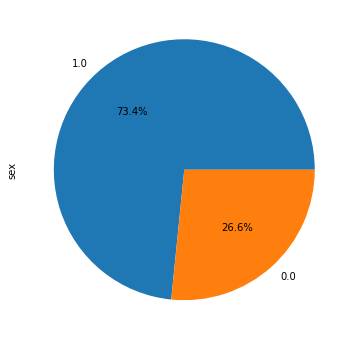

In [54]:
plot_pie_values_col(ds=iter_imp_df, column="sex")

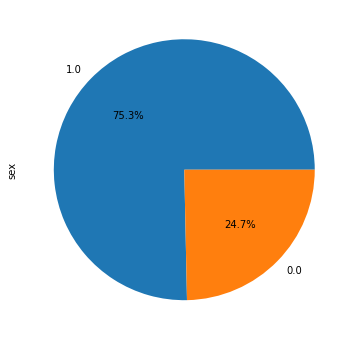

In [55]:
plot_pie_values_col(ds=randsamp, column="sex")

In [56]:
stratsamp = iter_imp_df.groupby("sex", group_keys=False).apply(
    lambda x: x.sample(frac=0.2)
)
stratsamp

Id      Synt   age  ...  resting_ecg  sex  st_slope
815   1815.0  0.407086  63.0  ...     0.000000  0.0       1.0
327   1327.0  0.624542  54.0  ...     0.000000  0.0       1.0
376   1376.0  0.429798  54.0  ...     0.000000  0.0       1.0
871   1871.0  0.347835  68.0  ...     2.000000  0.0       2.0
97    1097.0  0.626055  71.0  ...     2.000000  0.0       1.0
...      ...       ...   ...  ...          ...  ...       ...
961   1961.0  0.967580  56.0  ...     1.000000  1.0       2.0
912   1912.0  0.698435  56.0  ...     0.323705  1.0       2.0
1145  2145.0  0.091497  55.0  ...     0.000000  1.0       2.0
734   1734.0  0.427774  47.0  ...     0.000000  1.0       2.0
903   1903.0  0.401998  51.0  ...     0.000000  1.0       1.0

[229 rows x 13 columns]

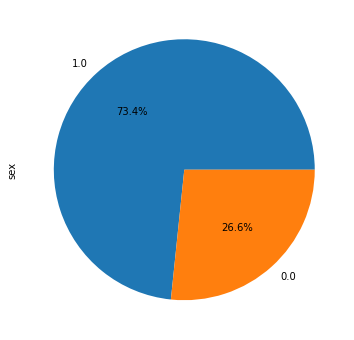

In [57]:
plot_pie_values_col(stratsamp, column="sex")

## Principal Component Analysis

In [81]:
# Decomposition of PCA
pca_decomp = PCA(n_components=2, whiten=True, random_state=RANDOM_STATE)
pca_decomp = pca_decomp.fit(iter_imp_df)

# Dataset PCA as Numpy array
iter_imp_pca_arr = pca_decomp.transform(iter_imp_df)

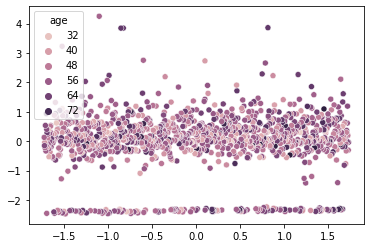

In [59]:
# Plot the pca clustered by age
sns.scatterplot(
    x=iter_imp_pca_arr[:, 0], y=iter_imp_pca_arr[:, 1], hue=iter_imp_df["age"]
)

## Feature Subset Selection

Techniques:
- Brute-force approach: Try all possible feature subsets as input to data mining algorithm
- Embedded approaches: Feature selection occurs naturally as part of the data mining algorithm
- Filter approaches: Features are selected before data mining algorithm is run
- Wrapper approaches: Use the data mining algorithm as a black box to find best subset of attributes

Techniques:
- Univariate approach:
    - KBest: Select features according to the k highest scores in univariate fashion (default using Analysis of Variance, aka ANOVA, scores).
- ModelBased approach: Feature selection using an estimator for feature ranking
    - Recursive Feature Elimination: Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features.
    - Sequential Feature Selection: This Sequential Feature Selector adds (forward selection) or removes (backward selection) features to form a feature subset in a greedy fashion.
    - Select From Model: Meta-transformer for selecting features based on importance weights.

### Univariate Approach

In [60]:
def get_feature_univ_scores(univ_fselector, columns, sort_by: str = "score"):
    return pd.DataFrame(
        data=[univ_fselector.scores_, univ_fselector.pvalues_],
        index=["score", "pvalue"],
        columns=columns,
    ).T.sort_values(by=sort_by, ascending=False)

#### Select KBest

In [61]:
# Create the feature selector
kbest = SelectKBest(k=3)
kbest.fit(iter_imp_df, target)

SelectKBest(k=3)

In [62]:
# Print selected columns
iter_imp_df.columns[kbest.get_support()]

Index(['chest_pain_type', 'exercise_angina', 'st_slope'], dtype='object')

In [63]:
# Feature selection scores and pvalues analysis
get_feature_univ_scores(kbest, iter_imp_df.columns, sort_by="score")

score        pvalue
st_slope             385.312318  3.226314e-74
exercise_angina      376.332810  9.491525e-73
chest_pain_type      271.713461  5.802042e-55
max_heart_rate       249.114856  6.026593e-51
oldpeak              243.315709  6.629012e-50
sex                  127.677019  3.779674e-28
age                   70.205698  1.541034e-16
fasting_blood_sugar   66.182263  1.057621e-15
cholesterol           46.783478  1.285098e-11
resting_bp_s          22.218921  2.730127e-06
Id                     5.778051  1.638500e-02
resting_ecg            0.914044  3.392445e-01
Synt                   0.596910  4.399182e-01

In [64]:
# Transform dataset selection columns
kbest.transform(iter_imp_df)

array([[4., 1., 2.],
       [4., 1., 2.],
       [4., 0., 1.],
       ...,
       [2., 0., 1.],
       [4., 1., 1.],
       [2., 0., 1.]])

### ModelBased Approach

#### Recursive Feature Elimination (Based On Regression)

In [65]:
def get_feature_rfe_ranking(
    mb_fselector, columns,
):
    return pd.DataFrame(
        data=[mb_fselector.ranking_], index=["ranking"], columns=columns,
    ).T.sort_values(by="ranking", ascending=True)

In [66]:
# Create the RecursiveFeatureElimination selector
rfe = RFE(
    estimator=LinearRegression(normalize=True), n_features_to_select=K_FEATURES, step=1
)
rfe.fit(iter_imp_df, target)

RFE(estimator=LinearRegression(normalize=True), n_features_to_select=3)

In [67]:
# Print selected columns
iter_imp_df.columns[rfe.support_]

Index(['exercise_angina', 'sex', 'st_slope'], dtype='object')

In [68]:
# Analyze feature ranking
get_feature_rfe_ranking(rfe, iter_imp_df.columns)

ranking
exercise_angina            1
sex                        1
st_slope                   1
fasting_blood_sugar        2
chest_pain_type            3
oldpeak                    4
Synt                       5
resting_ecg                6
max_heart_rate             7
age                        8
resting_bp_s               9
cholesterol               10
Id                        11

In [69]:
rfe.transform(iter_imp_df)

array([[1., 1., 2.],
       [1., 0., 2.],
       [0., 1., 1.],
       ...,
       [0., 1., 1.],
       [1., 1., 1.],
       [0., 0., 1.]])

#### Sequential Feature Selection (Based on Classification)

In [70]:
# Create the RecursiveFeatureElimination selector
sfs = SequentialFeatureSelector(
    estimator=DecisionTreeClassifier(max_depth=4),
    n_features_to_select=K_FEATURES,
    cv=5,
)
sfs.fit(iter_imp_df, target)

SequentialFeatureSelector(estimator=DecisionTreeClassifier(max_depth=4),
                          n_features_to_select=3)

In [71]:
# Print selected columns
iter_imp_df.columns[sfs.support_]

Index(['chest_pain_type', 'oldpeak', 'st_slope'], dtype='object')

In [72]:
sfs.transform(iter_imp_df)

array([[ 4.        ,  2.35592054,  2.        ],
       [ 4.        ,  1.50197009,  2.        ],
       [ 4.        , -0.02562722,  1.        ],
       ...,
       [ 2.        , -0.02791818,  1.        ],
       [ 4.        ,  1.90546989,  1.        ],
       [ 2.        ,  0.01344436,  1.        ]])

#### Select From Model

In [73]:
# Create the SelectFromModel selector
sfm = SelectFromModel(estimator=Lasso(), max_features=K_FEATURES)
sfm.fit(iter_imp_df, target)

SelectFromModel(estimator=Lasso(), max_features=3)

In [74]:
# Print selected columns
iter_imp_df.columns[sfm.get_support()]

Index(['cholesterol', 'max_heart_rate', 'resting_bp_s'], dtype='object')

In [75]:
sfm.transform(iter_imp_df)

array([[207.        , 131.        , 129.        ],
       [182.        , 140.        , 129.        ],
       [224.        , 186.        , 122.        ],
       ...,
       [213.92193538, 153.        , 109.        ],
       [205.        , 137.        , 141.        ],
       [231.        , 131.        , 150.        ]])

## Feature Construction

In [76]:
# Create a new feature called relative_bp_s as the ratio between resting blood pressure and cholesterol
iter_imp_df["bp_s_chol"] = iter_imp_df["resting_bp_s"] / (
    iter_imp_df["cholesterol"] + 1e-7
)
iter_imp_df["bp_s_chol"]

0       0.623188
1       0.708791
2       0.544643
3       0.440625
4       0.462406
          ...   
1147    0.841340
1148    0.821429
1149    0.509532
1150    0.687805
1151    0.649351
Name: bp_s_chol, Length: 1152, dtype: float64

## Attribute Transformation

In [77]:
# Apply logaritmic transformation and create a new transformed column
iter_imp_df["transformed_mhr"] = iter_imp_df["max_heart_rate"].apply(
    lambda x: max(min(x - x / np.sqrt(x), 120), 90)
)

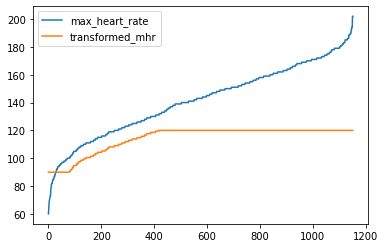

In [78]:
# Visualize the current transformation
iter_imp_df[["max_heart_rate", "transformed_mhr"]].sort_values(
    by="max_heart_rate", ignore_index=True
).plot.line()

## Data profiling


In [79]:
!pip freeze |grep pandas-profiling


pandas-profiling==2.11.0


In [80]:
pp.ProfileReport(dataset)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]